In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl

In [3]:
aisles_df = pl.read_csv("../data/aisles.csv")
departments_df = pl.read_csv("../data/departments.csv")
order_prior_df = pl.read_csv("../data/order_products__prior.csv")
order_train_df = pl.read_csv("../data/order_products__train.csv")
orders_df = pl.read_csv("../data/orders.csv")
products_df = pl.read_csv("../data/products.csv")

In [4]:
data = pl.read_csv("../data/feature_engineered_data.csv")

In [5]:
orders_df = orders_df.with_columns(
    pl.when(pl.col("eval_set") == "prior").then(0)
    .when(pl.col("eval_set") == "train").then(1)
    .when(pl.col("eval_set") == "test").then(2)
    .otherwise(pl.col("eval_set")).cast(pl.Int32).alias("eval_set")
)

In [6]:
# keeping only the train and test set from the order df

orders_future = orders_df.filter(
  (pl.col("eval_set") == 1) | (pl.col("eval_set") == 2)
).select(["user_id", "eval_set", "order_id"])

In [7]:
# merging the order_future with data
data = data.join(orders_future, on="user_id", how="left")

In [8]:
# preparing the training dataset

data_train = data.filter(
  pl.col("eval_set") == 1
)

In [9]:
# merging the information contained in the order_products__train.csv into data_train

data_train = data_train.join(order_train_df.select(["product_id", "order_id", "reordered"]), on=["product_id", "order_id"], how="left")

In [10]:
data_train = data_train.with_columns(
    pl.col("reordered").fill_null(strategy="zero").alias("reordered")
)

In [11]:
data_train = data_train.drop(["eval_set", "order_id"])

In [12]:
data_train.head()

user_id,product_id,uxp_times_bought,uxp_reorder_ratio,uxp_last_five,uxp_ratio_last_five,u_num_of_orders,u_avg_prd,dow_u_most_orders,hod_u_most_orders,u_reorder_ratio,average_days_between_orders,u_total_items_bought,p_num_of_times,p_reorder_ratio,p_avg_cart_position,reordered
i64,i64,i64,f64,i64,f64,i64,f64,i64,i64,f64,f64,i64,i64,f64,f64,i64
1,196,10,1.0,5,1.0,10,5.9,4,7,0.694915,18.542373,59,35791,0.77648,3.721774,1
1,10258,9,1.0,5,1.0,10,5.9,4,7,0.694915,18.542373,59,1946,0.713772,4.277492,1
1,10326,1,0.166667,0,0.0,10,5.9,4,7,0.694915,18.542373,59,5526,0.652009,4.191097,0
1,12427,10,1.0,5,1.0,10,5.9,4,7,0.694915,18.542373,59,6476,0.740735,4.760037,0
1,13032,3,0.333333,2,0.4,10,5.9,4,7,0.694915,18.542373,59,3751,0.657158,5.622767,1


In [13]:
data_test = data.filter(
  pl.col("eval_set") == 2
)

In [14]:
data_test = data_test.drop(["eval_set", "order_id"])

In [15]:
print(f" The shape of the train data set is {data_train.shape} and the test data set is {data_test.shape}")

 The shape of the train data set is (8474661, 17) and the test data set is (4833292, 16)


In [16]:
# adding aisle and department data

data_train = data_train.join(products_df.select(['product_id', 'aisle_id', 'department_id']), on="product_id", how="left")
data_test = data_test.join(products_df.select(['product_id', 'aisle_id', 'department_id']), on="product_id", how="left")

In [17]:
data_train = data_train.sort(by=["user_id", "product_id"])
data_test = data_test.sort(by=["user_id", "product_id"])

In [18]:
# mean encoding categorical variables

columns_mean = ["aisle_id", "department_id"]

for col in columns_mean:
  mean = (
    data_train
    .group_by(col)
    .agg(pl.col("reordered").mean())
    .rename({'reordered': f'{col}_mean'})
  )

  data_train = data_train.join(mean, on=col, how='left')
  data_test = data_test.join(mean, on=col, how='left')
  
  # Replace original column with mean values
  data_train = data_train.with_columns(pl.col(f'{col}_mean').alias(col))
  data_test = data_test.with_columns(pl.col(f'{col}_mean').alias(col))
  
  # Drop temporary mean column
  data_train = data_train.drop(f'{col}_mean')
  data_test = data_test.drop(f'{col}_mean')

In [19]:
# import ml packages

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import lightgbm as lgb

In [20]:
X = data_train.drop(['reordered', 'uxp_ratio_last_five'])
y = data_train.select(["reordered"])

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [22]:
parameters = {
    'max_depth' : 10,
    'colsample_bytree' : 0.4,
    'subsample' : 0.8,
    'num_leaves': 96,
    'objective': 'binary'
}

In [23]:
lgbm = lgb.LGBMClassifier(**parameters)

In [24]:
%%time
lgbm.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 580657, number of negative: 5351605
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013968 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2906
[LightGBM] [Info] Number of data points in the train set: 5932262, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.097881 -> initscore=-2.220992
[LightGBM] [Info] Start training from score -2.220992
CPU times: user 1min 3s, sys: 3.84 s, total: 1min 7s
Wall time: 13.1 s


LGBMClassifier(colsample_bytree=0.4, max_depth=10, num_leaves=96,
               objective='binary', subsample=0.8)

In [25]:
y_pred = (lgbm.predict_proba(X_test)[:, 1] >= 0.21).astype('int')

print('F1 Score: {}'.format(f1_score(y_pred, y_test)))
print(classification_report(y_pred, y_test))

F1 Score: 0.43355165565877013
              precision    recall  f1-score   support

           0       0.91      0.94      0.93   2209468
           1       0.51      0.38      0.43    332931

    accuracy                           0.87   2542399
   macro avg       0.71      0.66      0.68   2542399
weighted avg       0.86      0.87      0.86   2542399



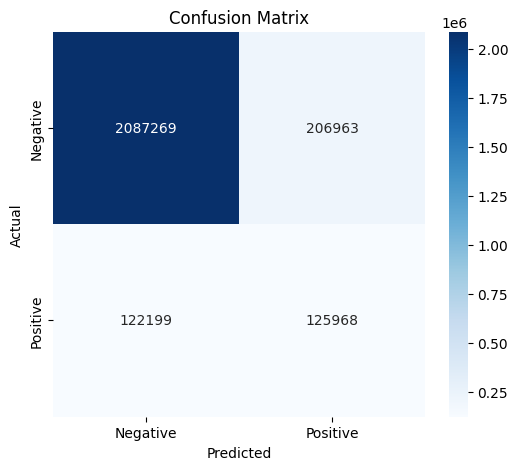

In [26]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

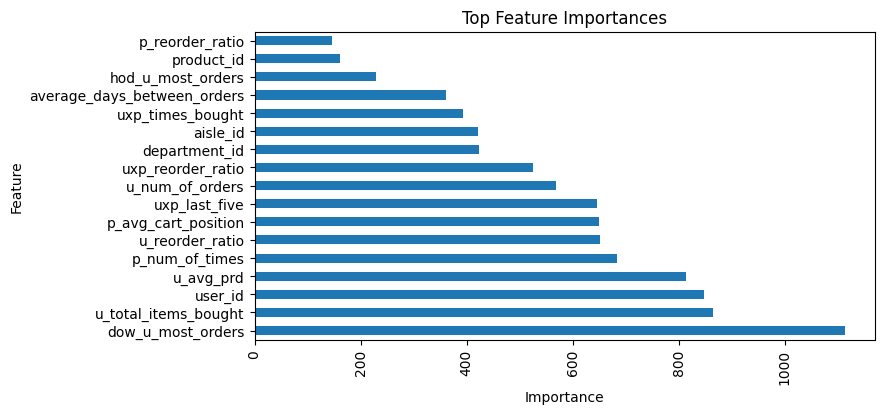

In [27]:
importances = lgbm.feature_importances_

columns = pd.Index(data_test.columns)
columns = columns.difference(["uxp_ratio_last_five"])
features = pd.Series(importances, index=columns)
features = features.sort_values(ascending=False)
top_features = features.head(20)

plt.figure(figsize=(8, 4))
top_features.plot(kind='barh')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top Feature Importances')
plt.xticks(rotation=90)
plt.show()

In [28]:
lgbm.fit(data_train.drop(['reordered', 'uxp_ratio_last_five']), data_train.select(["reordered"]))

[LightGBM] [Info] Number of positive: 828824, number of negative: 7645837
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044187 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2904
[LightGBM] [Info] Number of data points in the train set: 8474661, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.097800 -> initscore=-2.221909
[LightGBM] [Info] Start training from score -2.221909


LGBMClassifier(colsample_bytree=0.4, max_depth=10, num_leaves=96,
               objective='binary', subsample=0.8)

In [29]:
y_pred_test = (lgbm.predict_proba(data_test.drop('uxp_ratio_last_five'))[:, 1] >= 0.21).astype('int')

In [30]:
data_test = data_test.with_columns(
  pl.Series("prediction", y_pred_test)
)

In [31]:
final = data_test.select(["product_id", "user_id", "prediction"])

In [32]:
order_test = orders_df.filter(
  pl.col("eval_set") == 2
).select(["user_id", "order_id"])

In [33]:
final = final.join(order_test, on="user_id", how="left")
final = final.drop("user_id")

In [34]:
d = {}

for row in final.filter(pl.col("prediction") == 1).rows():
    order_id = row[final.columns.index("order_id")]
    product_id = row[final.columns.index("product_id")]
    
    if order_id in d:
        d[order_id] += ' ' + str(product_id)
    else:
        d[order_id] = str(product_id)


for order in final["order_id"]:
    if order not in d:
        d[order] = 'None'

In [35]:
sub = pl.DataFrame(list(d.items()), schema=["order_id", "products"])

sub.head()

order_id,products
i64,str
2774568,"""17668 18599 21903 22035 39190 …"
1528013,"""21903 38293"""
1376945,"""8309 13176 14947 27959 28465 3…"
1356845,"""7076 10863 11520 13176 14992 2…"
2161313,"""196 10441 11266 12427 14715 27…"


In [36]:
sub.write_csv('../submissions/submission_lightgbm.csv', include_header=True)